# United States census data - income level prediction  

This notebook will present the analysis of a dataset from the United States Census Bureau, in order to predict wether a person is making more or less than $50,000 per year.  
The studied dataset contains demographic and economic information about ~300,000 individuals.  
This notebook will present :
- An exploratory data analysis of the dataset,  
- The feature engineering steps,  
- The modeling of the dataset regarding the target variable,  
- An assessment of the models,
- An analysis of the model results.

## 1. Set-up and data loading

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interactive, fixed
import warnings
import shap
from sklearn.metrics import ConfusionMatrixDisplay

from lib import data, visualization, ml_processing

plt.style.use("seaborn-v0_8")

RANDOM_SEED = 2910

%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data will be automatically downloaded thanks to the following function:

In [10]:
data.download_data()

The data is already downloaded in data/


The data is then imported as DataFrames, taking care of the type of each columns as there are some numerical and categorical variables.

In [7]:
learn_df, test_df, learn_test_df = data.load_data()

Loading learn data...
Loading test data...
Process columns...
Done


In [11]:
# List of columns by types
numerical_cols = list(learn_df.columns[learn_df.dtypes == int])
categorical_cols = list(learn_df.columns[learn_df.dtypes == "category"])
target = ">50000"

## 2. Exploratory data analysis

### 2.1 General information  
We start by getting some general information about the dataset:

In [12]:
print(f"Entries in learn data: {len(learn_df)}")
print(f"Entries in test data: {len(test_df)}")

Entries in learn data: 199523
Entries in test data: 99762


In [13]:
print("Proportions of unknown values:")
missing_values = pd.concat(
    [
        (learn_df.isin(["?", "Missing value"])).sum() / len(learn_df),
        (test_df.isin(["?", "Missing value"])).sum() / len(test_df),
    ],
    axis=1,
).rename(columns={0: "learn", 1: "test"})
missing_values[missing_values.sum(axis=1) > 0]

Proportions of unknown values:


,learn,test
hispanic origin,0.004380,0.004060
state of previous residence,0.003548,0.003308
migration code-change in msa,0.499672,0.500652
migration code-change in reg,0.499672,0.500652
migration code-move within reg,0.499672,0.500652
migration prev res in sunbelt,0.499672,0.500652
country of birth father,0.033645,0.034372
country of birth mother,0.030668,0.030793
country of birth self,0.017006,0.017682


The migration-related columns contain around half of unknown values and thus are not very informative. We will probably drop them for the modeling steps.

We can also count the proportions of undefined values, such as "not in universe", "do not know, "NA" and the like:

In [14]:
print("Proportions of undefined values:")
unknown_values = pd.concat(
    [
        learn_df.isin(["Not in universe", "Do not know", "NA", "All other"]).sum()
        / len(learn_df),
        test_df.isin(["Not in universe", "Do not know", "NA", "All other"]).sum()
        / len(test_df),
    ],
    axis=1,
).rename(columns={0: "learn", 1: "test"})
unknown_values[unknown_values.sum(axis=1) > 0]

Proportions of undefined values:


,learn,test
class of worker,0.502423,0.501985
enroll in edu inst last wk,0.936950,0.936469
major occupation code,0.504624,0.504030
hispanic origin,0.863124,0.862683
member of a labor union,0.904452,0.904984
reason for unemployment,0.969577,0.968625
region of previous residence,0.920946,0.922876
state of previous residence,0.920946,0.922876
migration code-change in msa,0.007598,0.007247
migration code-change in reg,0.007598,0.007247


We notice that a few columns contain a lot of undefined values as well, we might also drop some of them during the modeling process due to the poor information they provide.

### 2.2 Target distribution

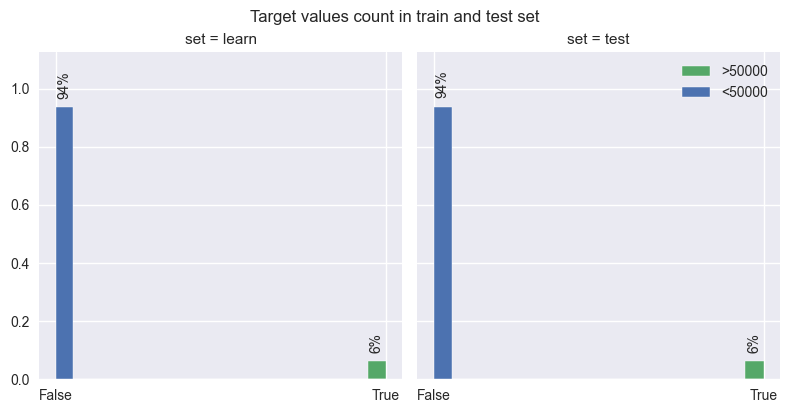

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Annoying seaborn warning

    g = sns.FacetGrid(learn_test_df, col="set", height=4, aspect=1)  # type: ignore
    g.map_dataframe(
        sns.histplot,
        x=target,
        hue=target,
        stat="probability",
        legend=True,
        alpha=1,
    )
    plt.xticks([1.0, 0.0], ["True", "False"])
    plt.legend([">50000", "<50000"])
    plt.suptitle("Target values count in train and test set", y=1.02)

    for ax in g.axes.ravel():
        for c in ax.containers:
            labels = [f"{w*100:.0f}%" if (w := v.get_height()) > 0 else "" for v in c]
            ax.bar_label(
                c,
                labels=labels,
                label_type="edge",
                fontsize=10,
                rotation=90,
                padding=6,
            )
        ax.margins(y=0.2)

    plt.show()

We notice a very strong unbalance in the dataset: only around 6% of the people get an income higher than $50000. We will have to take that into account to model the data and assess the results: a model predicting only the <50000 class would have a 94% accuracy, so it will be more usefull to study other metrics to evaluate the models.  
We also notice that the distribution is similar between learn and test sets.

### 2.3 Numerical columns  
To study the distribution of numerical columns, we use an interactive plot that will help to better navigate between the different information. Some variables are also better represented with a logarithmic scale due to their distribution:

In [16]:
interactive(
    visualization.plot_learn_test_variable_histograms,
    df=fixed(learn_test_df),
    variable=numerical_cols,
    target=fixed(target),
)

interactive(children=(Dropdown(description='variable', options=('age', 'wage per hour', 'capital gains', 'capi…

We notice several interesting information:  
- The age are going from 0 to 90 years old so we get data from children and adults alike. This feature seems informative as the distribution is very different between the >50000 and <50000 classes.  
- The wage per hour also has different distributions between the 2 classes. It seems that this data is reported in cents. Strangely, a lot of people from the >50000 class also have a wage per hour near 0 values.  
- Capital gains and capital losses have different distributions between the 2 classes, with high income individuals having more gains and losses in general.
- The "dividends from stocks" column is informative as only >50000 individuals are associated with high dividends. This data is also probably reported in cents.  
- High income individuals are associated with more persons working for the employer, while half of the lower income individuals are associated with 0 person working for the employer. It is unclear why this feature is limited to 6 (maybe the data of this column has been encoded as ordinal ?).  
- More than 80% of high income individuals are working 52 weeks, while 50% of low income individuals are not working during the year (a lot of them probably being children).
- The distribution are pretty similar between the learn and the test set.

Next we plot the linear correlation matrix between numerical features:

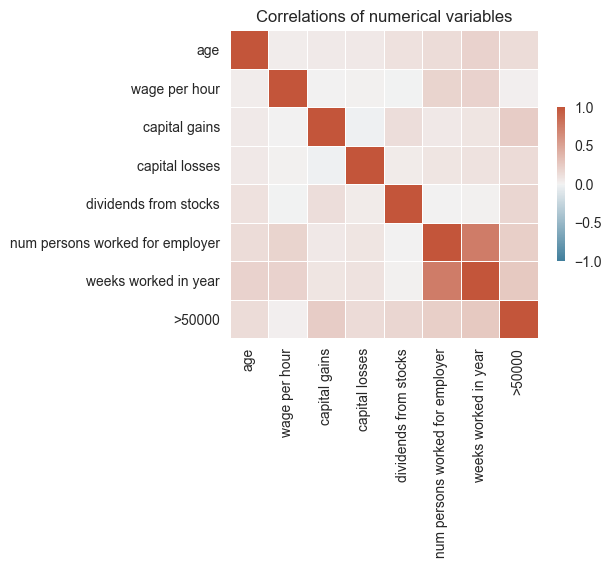

In [17]:
corr = learn_test_df[numerical_cols + [target]].corr()

_, ax = plt.subplots(figsize=(5, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,  # type: ignore
    cbar_kws={"shrink": 0.5},
)
plt.title("Correlations of numerical variables")
plt.show()

We see that the strongest correlation is between "num persons worked for employer" and "weeks worked in year". It seems logical as people working 0 weeks a year would also fall in the "0 persons worked for employer" category.  
Beside this, correlations are pretty weak. We notice low positive correlations between the target and the features, and the correlation with "wage per hour" is almost 0.

### 2.4 Categorical columns  
We conduct the same type of analysis with categorical columns:

In [18]:
interactive(
    visualization.plot_learn_test_variable_histograms,
    df=fixed(learn_test_df),
    variable=categorical_cols,
    target=fixed(target),
)

interactive(children=(Dropdown(description='variable', options=('class of worker', 'detailed industry recode',…

Here are the main information we get from the categorical distribution plots:  
- High income individuals are associated with:  
        - private class of worker,  
        - detailed occupation recode category 2,  
        - bachelor or master's degrees,  
        - married-civilian and spouse present,  
        - executive and managerial, professional specialty, and sales occupations,
        - being a male,  
        - full-time employment,  
        - tax-filer status being "joint both under 65",  
        - being a housholder,  
        - having veterans benefits status "2".
- Low income individuals are associated with:  
        - "Not in universe" class of worker (probably corresponding to not working, or child),  
        - detailed industry recode and detailed operation recode category 0,  
        - high school graduate education,  
        - never having been married, non tax filler: probably those are proxy for being a child (no other classes seem to accomodate them in the corresponding columns),  
        - being a female,  
        - veterans benefits class 0
- As noted before, we see a lot of unknown values for the migration-related columns.  
- The distributions of features between the learn and test sets are alos pretty similar.

As for the numerical features, it is usefull to evaluate the correlations between the categorical columns, but it is not possible to compute it in the same way.  
We can construct a matrix of [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) association measures, which represents how much a variable is determined by the other:

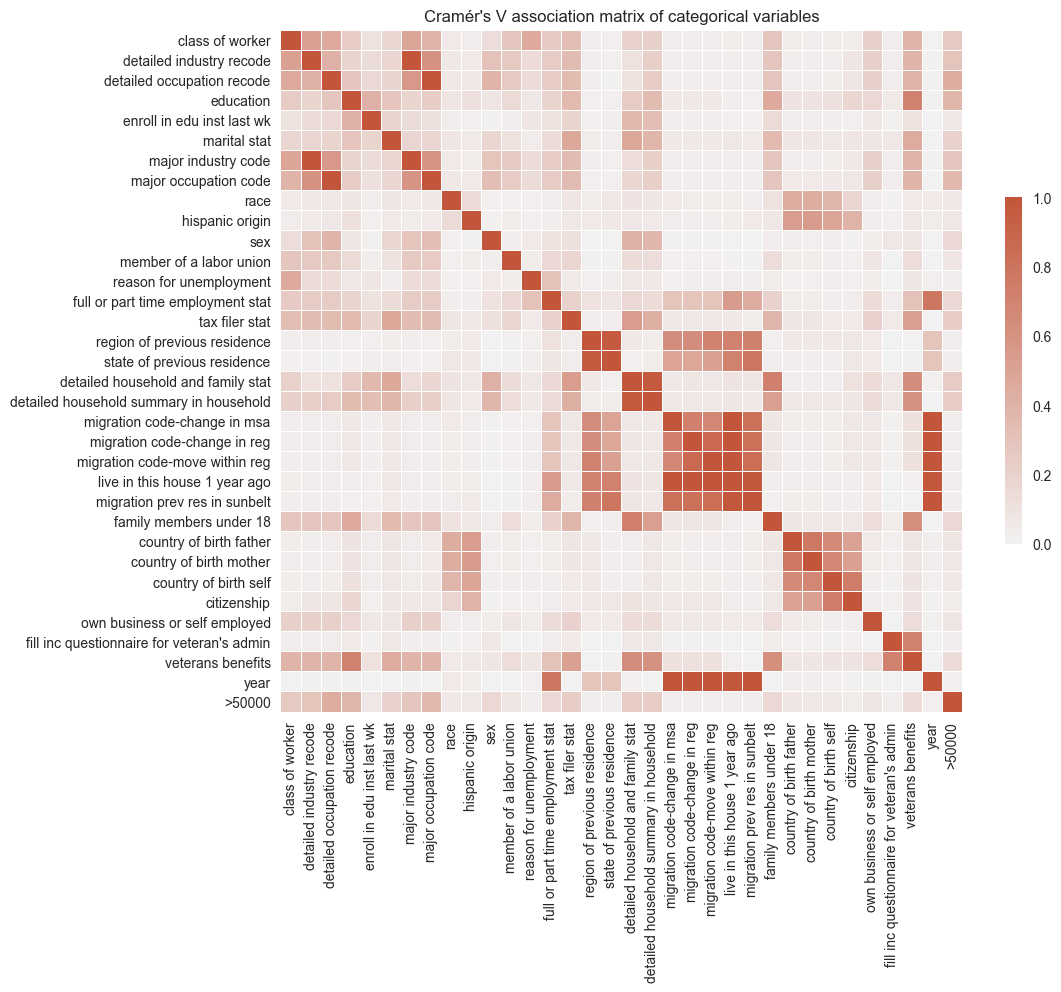

In [19]:
cramers_matrix = visualization.cramers_matrix(
    learn_test_df, categorical_cols + [target]
)

_, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    cramers_matrix,
    cmap=cmap,
    vmin=0,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,  # type: ignore
    cbar_kws={"shrink": 0.5},
)
plt.title("Cramér's V association matrix of categorical variables")
plt.show()

We notice a few expected relationships: the columns related to migration are all strongly correlated between themseleves, as well as the country of birth columns, and previous residence columns. Major and detailed industry, and major and detailed occupations are also correlated as expected. We notice a strong correlation between year and the migration columns, maybe this is due to a change in the polling answer options between 1994 and 1995?  
These observations will be helpful during the feature selection process for modeling.

## 3 Features selection  
Based on the exploratory data analysis, we proceed to feature selection by:  
- removing variables with partial information (too many unknown or undefined entries),  
- removing unrelevant variables regarding the target,  
- removing redundant categorical variables based on the Cramér's V association matrix. 

In [20]:
categorical_features = [
    "class of worker",
    "education",
    "marital stat",
    "major industry code",
    "major occupation code",
    "race",
    "sex",
    "full or part time employment stat",
    "tax filer stat",
    "detailed household summary in household",
    "family members under 18",
    "citizenship",
    "own business or self employed",
    "veterans benefits",
]

numerical_features = [
    "age",
    "wage per hour",
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "num persons worked for employer",
    "weeks worked in year",
]

At this point, there are a lot of duplicate entries in the learn dataset. We remove them in order to give an equal weight to all the distinct data points (I noticed it consistently improved the modeling results):

In [21]:
print(
    f"Number of rows in the learn dataset before dropping duplicates: {len(learn_df)}"
)
filtered_learn_df = learn_df.drop_duplicates()
print(
    f"Number of rows in the learn dataset after dropping duplicates: {len(filtered_learn_df)}"
)

Number of rows in the learn dataset before dropping duplicates: 199523
Number of rows in the learn dataset after dropping duplicates: 152896


## 4. Feature engineering and machine learning pipelines  
We will model the data with 3 different algorithms: a logistic regression, a decision tree, and a histogram gradient boosting.  
Their results will be assessed and compared in the next step.  
As these 3 algorithms have different requirements for their input data in the scikit-learn implementations, we build 3 pipelines with adapted feature engineering steps:  
- Logisitc regression needs scaled numerical features, and categorical features have to be encoded, we will use one-hot encoding for this.  
- Decision tree needs encoded categorical features, we will also use one-hot encoding.  
- Histogram gradient boosting can handle categorical features but not in a string format, we will use an ordinal encoder to convert strings to numbers.  

We try to counter the high unbalance of the dataset by passing the parameter `class_weight="balanced"` to each model, which will equalize the data by giving a more important weight to positive exemples.

In [22]:
X_learn = filtered_learn_df[categorical_features + numerical_features].copy()
y_learn = filtered_learn_df[target].copy()
X_test = test_df[categorical_features + numerical_features].copy()
y_test = test_df[[target]].copy()

In [27]:
pipelines = ml_processing.build_processing_pipelines(
    X_learn, numerical_features, categorical_features
)

In [28]:
pipelines, metrics_df = ml_processing.train_and_evaluate_models(
    pipelines, X_learn, X_test, y_learn, y_test
)

Training logistic regression...
Training decision tree...
Training histogram gradient boosting...


## 5. Models assessment  
We will now compare the metrics of the different models on the test data.  
The major difficulty with this dataset is the great unbalance between the target classes. To evaluate the performances, we look at the precision, the recall and the f1-score regarding the > 50000 class (the minority class), the accuracies and error rates are also computed for reference. We also look at the confusion matrices normalized by True labels, meaning, the proportion of correct and incorrect predictions for both classes. 

In [37]:
metrics_df

,precision (>50000 class),recall (>50000 class),f1_score (>50000 class),accuracy,error_rate
logistic regression,0.311293,0.867604,0.458189,0.872767,0.127233
decision tree,0.432632,0.465082,0.448270,0.929011,0.070989
histogram gradient boosting,0.355519,0.866958,0.504255,0.894298,0.105702


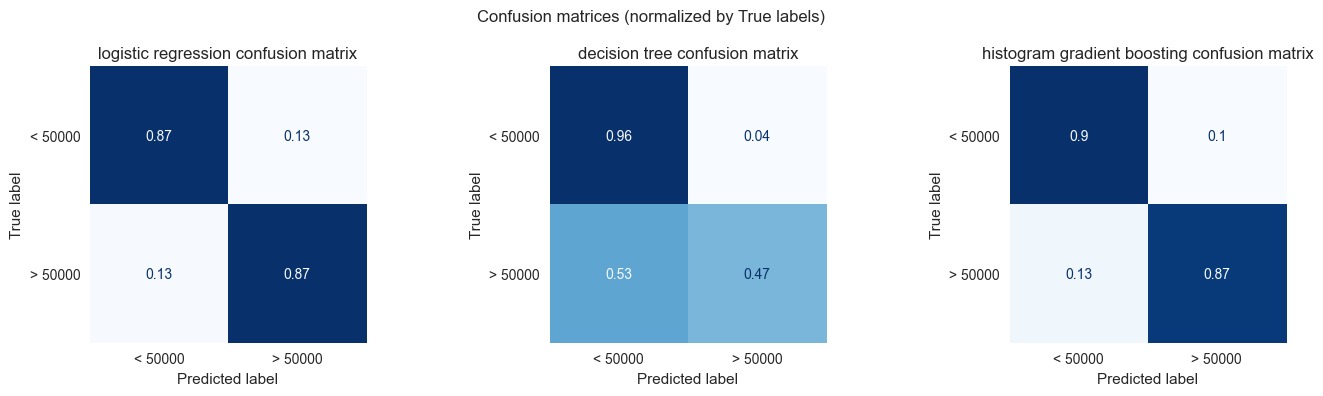

In [36]:
_, axs = plt.subplots(1, 3, figsize=(14, 4))
for i, model_name in enumerate(
    [
        "logistic regression",
        "decision tree",
        "histogram gradient boosting",
    ]
):
    ConfusionMatrixDisplay.from_predictions(
        y_test[target],
        y_test[f"pred_{model_name}"],
        normalize="true",
        colorbar=False,
        cmap=plt.cm.Blues,  # type: ignore
        ax=axs[i],
    )
    axs[i].set_title(f"{model_name} confusion matrix")
    axs[i].grid(False)
    axs[i].set_xticklabels(["< 50000", "> 50000"])
    axs[i].set_yticklabels(["< 50000", "> 50000"])

plt.suptitle("Confusion matrices (normalized by True labels)")
plt.tight_layout()

We can make a few interesting observations:  
- Logistic regression and gradient boosting have a fairly good recall but low precision, meaning there are a few false negative but a lot of false positive. It seems that balancing the weights of each class worked as > 50000 are detected, but now a lot of < 50000 are also wrongly classified in this category.  
- The weight balancing of the classes seems to not have worked that much for decision tree, which has a stronger precision but a poor recall. This model has a higher accuracy than the 2 others, but at the expense of not being capable of correctly detecting > 50000 exemples.  

Overall, the choice of the best model depends on the objective: do we want to priorize a good detection of the few > 50000 individuals, to have a low error rate in general, or to have the best balance between recall and precision for the > 50000 class?  
For the next steps, I will make the assumption that a good balance between recall and precision is important regarding the > 50000 class. Thus, I will use the gradient boosting model which has the best f1-score, and the best confusion matrix.

## Results & insights

In [ ]:
X_learn_sample = X_learn.sample(10000, random_state=RANDOM_SEED)

In [ ]:
X_shap_sample = pd.DataFrame(
    hgb_pipeline["col_trans"].transform(X_learn_sample), columns=X_learn_sample.columns
)

In [35]:
explainer = shap.TreeExplainer(hgb_pipeline["model"], X_shap_sample)
shap_values = explainer(X_shap_sample)

 99%|===================| 9869/10000 [00:27<00:00]        

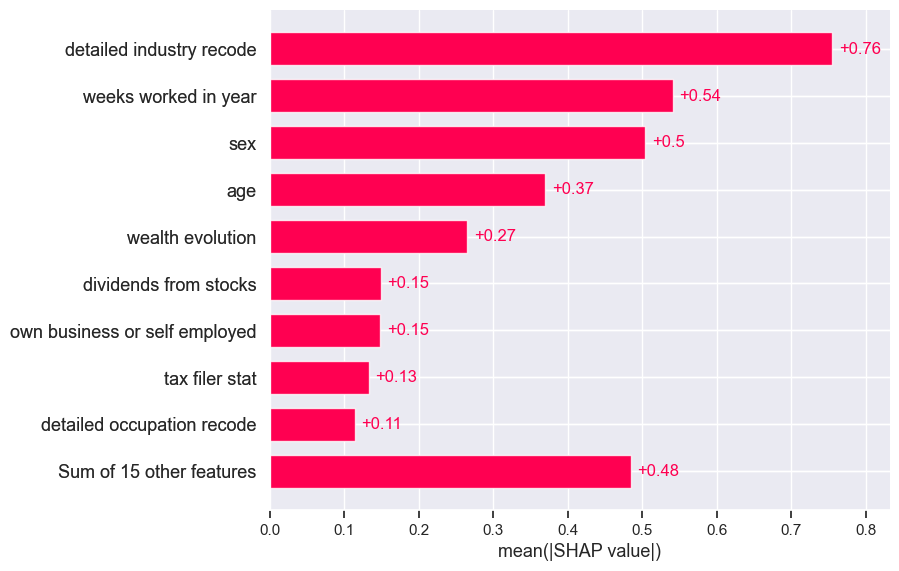

In [36]:
shap.plots.bar(shap_values)

In [37]:
most_important_features = X_shap_sample.columns[
    np.argsort(np.mean(np.abs(shap_values.values), axis=0))[::-1][:5]
]